In [1]:
# Deep Convolution Neural Network-based Remaining Useful Life Prediction Using NASA Turbofan Dataset
#This implementation uses only the sensor readings and rectified RUL

In [2]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Conv1D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

Using TensorFlow backend.


In [3]:
#Train_data is a cleaned train_FD001
train_data=pd.read_csv("/content/sample_data/Train_data.csv")

#Engine number 21 sensor readings are used as the test
test_data=pd.read_csv("/content/sample_data/train_21_engine_new.csv")

In [4]:
train_data.head()

,id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,R_early
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125


In [5]:
test_data.head()

,id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,R_early
0,21,1,642.24,1582.88,1410.66,553.57,2388.07,9047.42,47.44,521.76,2388.06,8128.48,8.4181,395,38.90,23.3554,125
1,21,2,642.27,1582.13,1404.54,553.22,2388.03,9043.88,47.25,521.39,2388.05,8120.15,8.3895,392,38.81,23.2300,125
2,21,3,642.47,1589.73,1408.88,553.21,2388.11,9048.33,47.43,521.26,2388.12,8124.89,8.4454,392,38.69,23.3471,125
3,21,4,642.50,1587.18,1409.45,553.30,2388.05,9052.17,47.35,521.81,2388.08,8126.21,8.3913,393,39.00,23.4179,125
4,21,5,642.21,1596.51,1401.46,553.03,2388.04,9047.48,47.57,521.82,2388.10,8130.92,8.4825,393,38.88,23.2637,125


In [6]:
#Normalize the training set
cols_normalize = train_data.columns.difference(['id','cycle','R_early'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_data[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_data.index)
join_df = train_data[train_data.columns.difference(cols_normalize)].join(norm_train_df)
train_data = join_df.reindex(columns = train_data.columns)
print(train_data.head())

   id  cycle   sensor2   sensor3  ...  sensor17  sensor20  sensor21  R_early
0   1      1  0.183735  0.406802  ...  0.333333  0.713178  0.724662      125
1   1      2  0.283133  0.453019  ...  0.333333  0.666667  0.731014      125
2   1      3  0.343373  0.369523  ...  0.166667  0.627907  0.621375      125
3   1      4  0.343373  0.256159  ...  0.333333  0.573643  0.662386      125
4   1      5  0.349398  0.257467  ...  0.416667  0.589147  0.704502      125

[5 rows x 17 columns]


In [7]:
#Normalize the test set
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_data[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_data.index)
test_join_df = test_data[test_data.columns.difference(cols_normalize)].join(norm_test_df)
test_data = test_join_df.reindex(columns = test_data.columns)
test_data = test_data.reset_index(drop=True)
print(test_data.head())

   id  cycle   sensor2   sensor3  ...  sensor17  sensor20  sensor21  R_early
0  21      1  0.310241  0.258121  ...  0.583333  0.589147  0.636841      125
1  21      2  0.319277  0.241770  ...  0.333333  0.519380  0.463684      125
2  21      3  0.379518  0.407456  ...  0.333333  0.426357  0.625380      125
3  21      4  0.388554  0.351864  ...  0.416667  0.666667  0.723143      125
4  21      5  0.301205  0.555265  ...  0.416667  0.573643  0.510218      125

[5 rows x 17 columns]


In [8]:
train_data.head()

,id,cycle,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,R_early
0,1,1,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,125
1,1,2,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,125
2,1,3,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,125
3,1,4,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,125
4,1,5,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,125


In [9]:
# Sliding window size of 40 cycles
sequence_length = 40

# function to reshape features into (samples, time steps, features) 

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length),
                           range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [10]:
#  Select useful sensors only feature columns
sequence_cols = ['sensor2','sensor3','sensor4','sensor7','sensor8','sensor9',
                 'sensor11','sensor12','sensor13','sensor14','sensor15',
                 'sensor17','sensor20','sensor21']

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_data[train_data['id']==id], 
                             sequence_length, sequence_cols)) 
           for id in train_data['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)


(16631, 40, 14)


In [11]:
# function to generate labels
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_data[train_data['id']==id], sequence_length,
                        ['R_early']) 
             for id in train_data['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(16631, 1)

In [12]:
# Metrics using keras backend
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [13]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# Create Model

In [14]:
# Clear artifacts and set random seed to ensure repeatability
keras.backend.clear_session()
np.random.seed(42)

#Create model

def DCNN():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(32, 8, padding='same', activation='relu',
                                  input_shape=(sequence_length,nb_features)))
    model.add(keras.layers.Conv1D(64, 8, padding='same', activation='relu'))
    model.add(keras.layers.Conv1D(64, 8, padding='same', activation='relu'))
    model.add(keras.layers.Conv1D(32, 8, padding='same', activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dropout(0.5))
    #model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='linear'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units=nb_out))
    optimizer = keras.optimizers.rmsprop(lr=1e-5)
    model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=([rmse,r2_keras]))
    return model

#Creat model checkpoint to save the best model performance
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

#specify ealy_callback to stop training model if there's no improvement after 10 epochs    
early_stopping = keras.callbacks.EarlyStopping(patience=10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 32)            3616      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 64)            16448     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 40, 64)            32832     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 40, 32)            16416     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)              

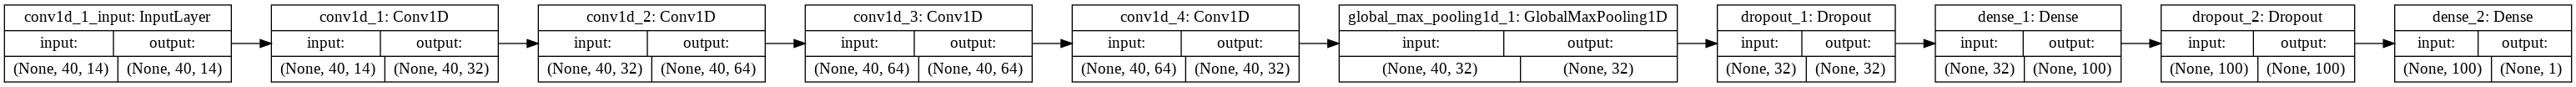

In [15]:
# Check the model architecture

New_DCNN=DCNN()
New_DCNN.summary()

# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(New_DCNN, show_shapes=True, rankdir="LR")          

In [16]:
# Train the model
history = New_DCNN.fit(seq_array,label_array, epochs=500, batch_size=200,
                       validation_split=0.2,callbacks=[early_stopping, 
                        model_checkpoint])

Train on 13304 samples, validate on 3327 samples
Epoch 1/500
13304/13304 [==============================] - 3s 208us/step - loss: 75.8553 - rmse: 76.3534 - r2_keras: -3.4335 - val_loss: 81.2542 - val_rmse: 81.7528 - val_r2_keras: -8.7137
Epoch 2/500
13304/13304 [==============================] - 1s 63us/step - loss: 75.4478 - rmse: 75.9459 - r2_keras: -3.4030 - val_loss: 80.7800 - val_rmse: 81.2772 - val_r2_keras: -8.6280
Epoch 3/500
13304/13304 [==============================] - 1s 62us/step - loss: 74.8896 - rmse: 75.3878 - r2_keras: -3.3499 - val_loss: 80.1187 - val_rmse: 80.6170 - val_r2_keras: -8.5082
Epoch 4/500
13304/13304 [==============================] - 1s 63us/step - loss: 74.1053 - rmse: 74.6035 - r2_keras: -3.2874 - val_loss: 79.1926 - val_rmse: 79.6909 - val_r2_keras: -8.3398
Epoch 5/500
13304/13304 [==============================] - 1s 63us/step - loss: 73.0291 - rmse: 73.5270 - r2_keras: -3.1740 - val_loss: 77.9145 - val_rmse: 78.4120 - val_r2_keras: -8.1069
Epoch 6/50

In [17]:
#load the best state of the model
model= load_model("my_checkpoint.h5", custom_objects={'r2_keras': r2_keras,'rmse':rmse})

In [18]:
# generate test sequences and convert to numpy array
test_gen = (list(gen_sequence(test_data[test_data['id']==id], sequence_length,
            sequence_cols)) for id in test_data['id'].unique())

# generate sequences and convert to numpy array
test_gen = np.concatenate(list(test_gen)).astype(np.float32)
#print(seq_array_test_last)
print(test_gen.shape)

(155, 40, 14)


In [19]:
# generate test labels
test_target = [gen_labels(test_data[test_data['id']==id], sequence_length,
               ['R_early']) for id in test_data['id'].unique()]

y_true = np.concatenate(test_target).astype(np.float32)
y_true.shape

(155, 1)

In [20]:
#predict on the test data
RUL_pred = model.predict(test_gen)

In [21]:
RUL_pred.shape

(155, 1)

In [22]:
y_true.shape

(155, 1)

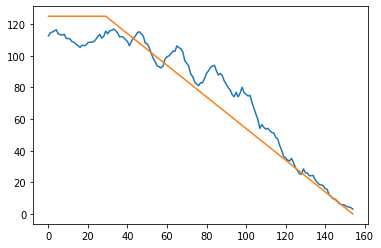

In [23]:
#Plot the predicted versus true RUL trend
time = np.arange(test_gen.shape[0])
plt.plot(time,RUL_pred)
plt.plot(time, y_true)
plt.show()

dict_keys(['val_loss', 'val_rmse', 'val_r2_keras', 'loss', 'rmse', 'r2_keras'])


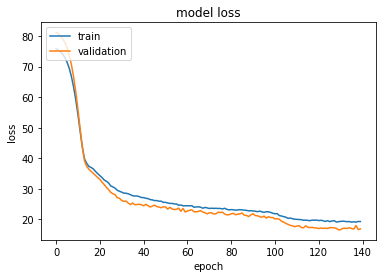

In [24]:
#Plot the losses  
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
#Estimate the model average rmse
final_mse = keras.metrics.mean_squared_error(y_true, RUL_pred)
final_rmse = np.sqrt(final_mse)
final_rmse
np.mean(final_rmse)

9.257155